In [8]:
import json
import numpy as np
import pandas as pd

import lightgbm as lgb

from datetime import datetime
import os
import argparse
from sklearn.metrics import roc_auc_score, accuracy_score
from process_data import process_data
from split_data import split_data

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, classification_report
from scipy.stats import ks_2samp
from operator import itemgetter

In [3]:
df = pd.read_csv(os.path.join('data', 'data.csv'))
df = process_data(df)

target = 'Churn_Yes'
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df, target=target, test_size=0.15)

with open('config_one.json') as file:
    config = json.load(file)
    
params = {key: value for key, value in config.items()}
with open('config_one.json') as file:
    config = json.load(file)




model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)])


LGBMClassifier(col_sample_bytree=0.5, eval_metric='logloss', learning_rate=0.03,
               n_estimators=1000, num_leaves=40, objective='binary',
               random_state=17, reg_alpha=20, reg_lambda=20,
               scale_pos_weight=1.5, subsample=0.5, values_depth=-1,
               verbose=-100)

In [25]:
def classification_predictive_power(y, pred, scoring_func=lambda x: x):
    """
    makes 4 plots:
    first two plots are PDF and CDF of probabilities or scores (if additional scoring/transformation function is provided)
    the third plot is a confusion matrix and the final plot is a classification report
    the function also calculates KS statistic, AUC and accuracy
    """
    title_font_size = 14
    table_cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=1,as_cmap=True)
    
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(2,2, figsize=(18,14))

    #PDF
    ks_data = pd.DataFrame({'Target': y, 'prob': pred})
    ks_data['SCORE'] = ks_data['prob'].apply(scoring_func)
    sns.histplot(data=ks_data, x='SCORE', hue='Target',  stat='probability', kde=True, bins=20, common_bins=False, 
                 common_norm=False, palette=['darkorange', 'grey'], ax=ax[0][0], edgecolor='black')
    ax[0][0].set_title('PDF', fontsize=title_font_size)

    #CDF
    sns.kdeplot(data=ks_data,x='SCORE', hue='Target', cumulative=True, common_norm=False, common_grid=True,
                palette=['darkorange', 'grey'], ax=ax[0][1])
    ax[0][1].set_title('CDF', fontsize=title_font_size)

    #confusion matrix
    ConfusionMatrixDisplay.from_predictions(y, pred > 0.5, ax=ax[1][0], cmap=table_cmap)
    ax[1][0].grid(None)
    ax[1][0].set_title('Confusion Matrix', fontsize=title_font_size)

    # classification report
    cr = pd.DataFrame(itemgetter(*[str(i) for i in y.unique()])(classification_report(y, pred>.5, output_dict=True))).drop(columns = 'support')
    sns.heatmap(cr,annot=True,vmax=1,fmt='.5f',ax=ax[1][1],
                cmap=table_cmap)
    ax[1][1].set_title('Classification Report', fontsize=title_font_size)
    
    # KS, AUC, Accuracy
    fig.suptitle(f"""\
                 KS - {ks_2samp(ks_data.query('Target == 0')['SCORE'], ks_data.query('Target == 1')['SCORE'])[0]:.4f}\
                 AUC - {roc_auc_score(y, pred):.4f}\
                 Accuracy - {accuracy_score(y, pred>.5):.4f}""", y=.95, fontsize=16)
    
    fig.savefig(os.path.join('graphs', 'a.jpg'))


In [9]:
pred_test = model.predict_proba(X_test)[:,-1]

In [15]:
y_test = y_test.astype('float64')

In [22]:
print()

0.0 1.0


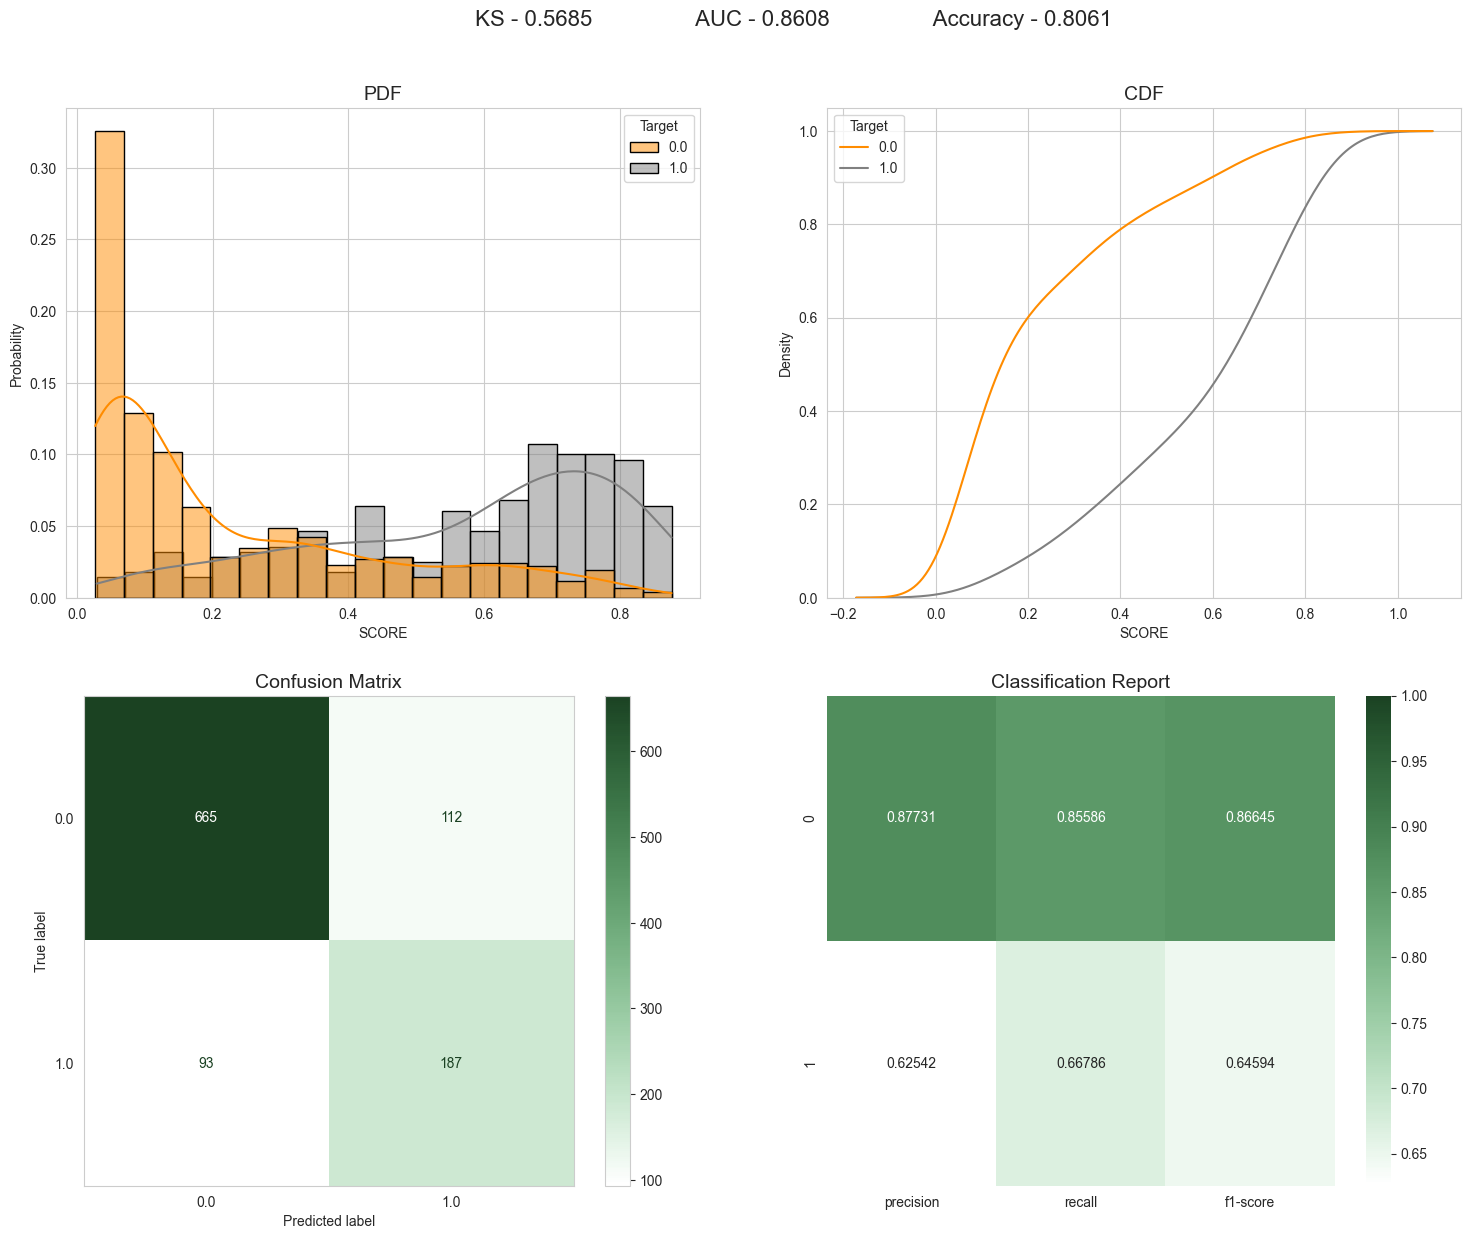

In [26]:
classification_predictive_power(y_test, pred_test)